In [225]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
  y_true,y_pred= np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/y_true)) *100  

In [226]:
data= pd.read_csv("cleaned_data_csv.csv")

In [227]:
data.head()

,Continent,Location,Date,Total_Cases,New_Cases,New cases smoothed,Total_deaths,New_deaths,new deaths smoothed,total cases per million,...,median age,aged 65 older,aged 70 older,extreme poverty,cardiovasc death rate,diabetes prevalence,female smokers,male smokers,hospital beds per thousand,life expectancy
0,Asia,Afghanistan,2020-02-24,5,5,0.0,1,0,0.0,0.126,...,18.6,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83
1,Asia,Afghanistan,2020-02-25,5,0,0.0,1,0,0.0,0.126,...,18.6,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83
2,Asia,Afghanistan,2020-02-26,5,0,0.0,1,0,0.0,0.126,...,18.6,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83
3,Asia,Afghanistan,2020-02-27,5,0,0.0,1,0,0.0,0.126,...,18.6,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83
4,Asia,Afghanistan,2020-02-28,5,0,0.0,1,0,0.0,0.126,...,18.6,2.581,1.337,0.2,597.029,9.59,1.9,24.7,0,64.83


In [228]:
def create_df(data, country):
    #Selecting the 7 key columns for country in dataset
    data=data[data['Location']==country].copy()
    data=data[['Date','Total_Cases','New_Cases',
         'Total_deaths','New_deaths',
         "people vaccinated per hundred", 'people_fully_vaccinated_per_hundred',
          'new cases per million']].copy()

    #Convert to datetime
    #data2.date = pd.to_datetime(data2['Date'])
    data['Date'] = pd.DatetimeIndex(data['Date'])
    return data

In [229]:
data2_india=create_df(data, 'India')

In [230]:
data2_india

,Date,Total_Cases,New_Cases,Total_deaths,New_deaths,people vaccinated per hundred,people_fully_vaccinated_per_hundred,new cases per million
69678,2020-01-30,1,1,1,0,0.00,0.00,0.001
69679,2020-01-31,1,0,1,0,0.00,0.00,0.000
69680,2020-02-01,1,0,1,0,0.00,0.00,0.000
69681,2020-02-02,2,1,1,0,0.00,0.00,0.001
69682,2020-02-03,3,1,1,0,0.00,0.00,0.001
...,...,...,...,...,...,...,...,...
70439,2022-03-01,42938599,7554,514246,223,69.32,56.82,5.421
70440,2022-03-02,42945160,6561,514388,142,69.34,56.92,4.709
70441,2022-03-03,42951556,6396,514589,201,69.36,57.11,4.590
70442,2022-03-04,42957477,5921,514878,289,69.38,57.27,4.249


In [231]:
data2_india=data2_india.loc[:,['Date','New_Cases']]
data2_india=data2_india.set_index('Date')

In [232]:
data2_india

,New_Cases
Date,
2020-01-30,1
2020-01-31,0
2020-02-01,0
2020-02-02,1
2020-02-03,1
...,...
2022-03-01,7554
2022-03-02,6561
2022-03-03,6396


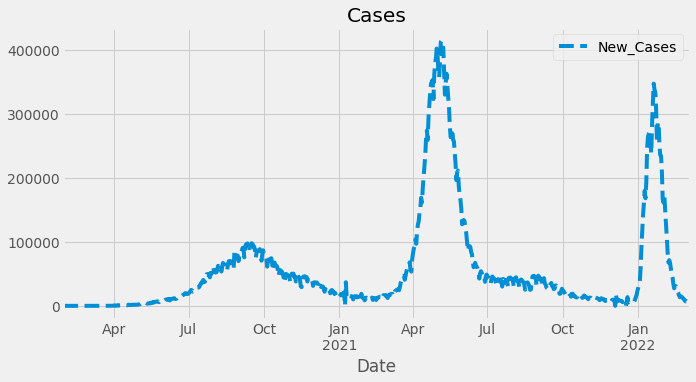

In [233]:
color_pal = sns.color_palette()
data2_india.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases')
plt.show()

In [234]:
from pandas.api.types import CategoricalDtype

cat_type= CategoricalDtype(categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],ordered=True)

def  create_features(df, label=None):
  df=df.copy()
  df['Date']=df.index
  df['hour']=df['Date'].dt.hour
  df['dayofweek']=df['Date'].dt.dayofweek
  df['weekday']=df['Date'].dt.day_name()
  df['weekday']=df['weekday'].astype(cat_type)
  df['quarter']=df['Date'].dt.quarter
  df['month']=df['Date'].dt.month
  df['year']=df['Date'].dt.year
  df['dayofyear']=df['Date'].dt.dayofyear
  df['dayofmonth']=df['Date'].dt.day
  df['weekofyear']=df['Date'].dt.weekofyear
  df['date_offset']=(df.Date.dt.month*100 + df.Date.dt.day - 320)%1300

  df['season']=pd.cut(df['date_offset'], [0,300, 602, 900,1300],
                      labels=['Spring','Summer','Fall','Winter']
                      )
  X=df[['hour','dayofweek','quarter','month','year','dayofyear',
        'dayofmonth','weekofyear','weekday',
        'season']]
  if label:
    y=df[label]
    return X,y
  return X

X,y = create_features(data2_india,label='New_Cases')
features_and_target = pd.concat([X,y],axis=1)         


In [235]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,New_Cases
Date,,,,,,,,,,,
2020-01-30,0,3,1,1,2020,30,30,5,Thursday,Winter,1
2020-01-31,0,4,1,1,2020,31,31,5,Friday,Winter,0
2020-02-01,0,5,1,2,2020,32,1,5,Saturday,Winter,0
2020-02-02,0,6,1,2,2020,33,2,5,Sunday,Winter,1
2020-02-03,0,0,1,2,2020,34,3,6,Monday,Winter,1


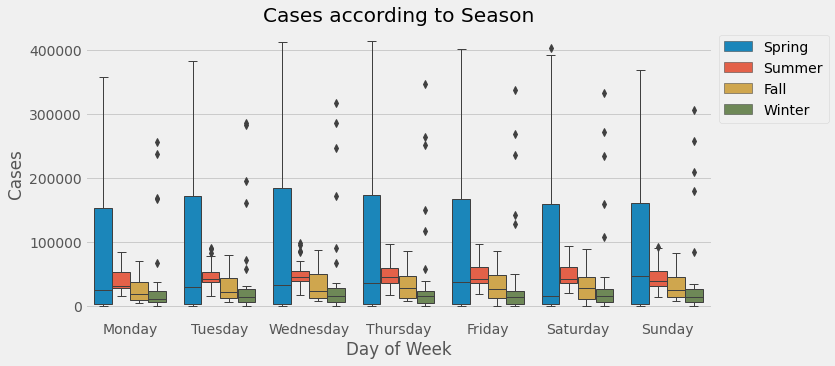

In [236]:
fig, ax=plt.subplots(figsize=(10,5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='New_Cases',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Cases according to Season')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Cases')
ax.legend(bbox_to_anchor=(1,1))
plt.show()


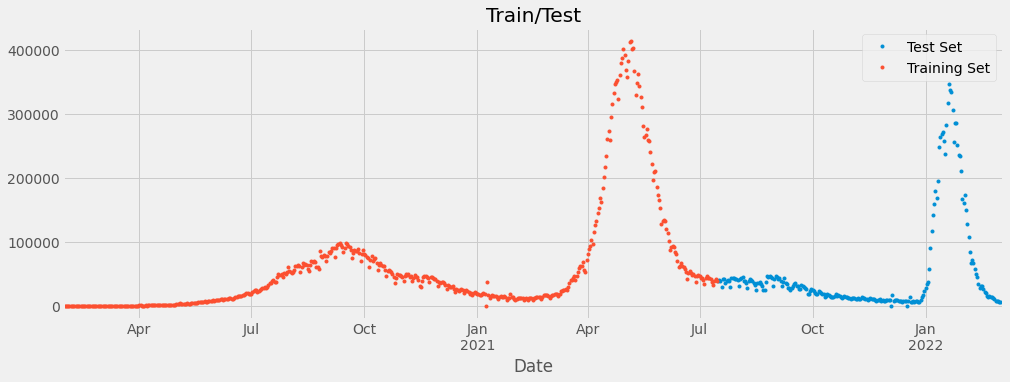

In [265]:
 split_date='15-July-2021'

 date_train = data2_india.loc[data2_india.index <=split_date].copy()
 date_test = data2_india.loc[data2_india.index >split_date].copy()

 date_test \
        .rename(columns={'New_Cases': 'Test Set'}) \
        .join(date_train.rename(columns={'New_Cases': 'Training Set'}),
              how='outer') \
        .plot(figsize=(15,5), title='Train/Test',style=".")
plt.show()

In [266]:

data2_india_prophet=date_test.groupby('Date').sum('New_Cases').reset_index() \
  .rename(columns={'Date':'ds',
                   'New_Cases':'y'})
  

In [267]:
data2_india_prophet.head()

,ds,y
0,2021-07-16,38079
1,2021-07-17,41157
2,2021-07-18,38164
3,2021-07-19,30093
4,2021-07-20,42015


In [268]:
%%time
model = Prophet()
model.fit(data2_india_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2iwbymem/2yn4tyh9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2iwbymem/y1g3wemp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27489', 'data', 'file=/tmp/tmp2iwbymem/2yn4tyh9.json', 'init=/tmp/tmp2iwbymem/y1g3wemp.json', 'output', 'file=/tmp/tmp2iwbymem/prophet_modellyv0b4g3/prophet_model-20230317222300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:23:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:23:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 56.6 ms, sys: 8.22 ms, total: 64.8 ms
Wall time: 107 ms


In [269]:
#predit on test set of model

data2_india_prophet=data2_india.reset_index() \
 .rename(columns={'Date':'ds',
                   'New_Cases':'y'})
#data2_india_fcst= model.predict(data2_india_prophet)

In [270]:
data2_india_prophet.tail()

,ds,y
761,2022-03-01,7554
762,2022-03-02,6561
763,2022-03-03,6396
764,2022-03-04,5921
765,2022-03-05,5476


In [271]:
#Create the model using Prophet 0.95 confidence
ML_Model = Prophet(interval_width=0.95)
#Fit the Model
ML_Model.fit(data2_india_prophet)
#Create prediction Data
Cases_Prediction = ML_Model.make_future_dataframe(periods=360)
Cases_Prediction.tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2iwbymem/9_p1_ur7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2iwbymem/jhn4ae2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67269', 'data', 'file=/tmp/tmp2iwbymem/9_p1_ur7.json', 'init=/tmp/tmp2iwbymem/jhn4ae2_.json', 'output', 'file=/tmp/tmp2iwbymem/prophet_modelnu6hfz15/prophet_model-20230317222300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:23:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:23:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
1121,2023-02-24
1122,2023-02-25
1123,2023-02-26
1124,2023-02-27
1125,2023-02-28


In [272]:
#predicting the future with date, and upper and lower limit of y value
Cases_Forecast = ML_Model.predict(Cases_Prediction)
Cases_Forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1121,2023-02-24,105258.656765,-25350.319133,240976.422702
1122,2023-02-25,106558.488683,-31088.684252,244296.504000
1123,2023-02-26,105911.715358,-22916.592839,243266.492876
1124,2023-02-27,101032.855440,-30510.551799,248178.827448
1125,2023-02-28,108740.489760,-22924.446327,238533.144409


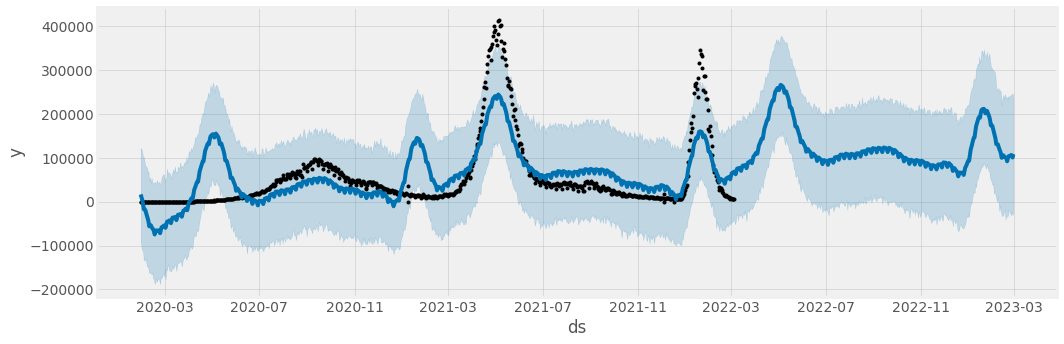

In [273]:
Cases_forecasting = ML_Model.plot(Cases_Forecast, figsize=(15,5))

In [274]:
#data2_india_fcst.head()

In [275]:
#fig,ax = plt.subplots(figsize=(10,5))
#fig= model.plot(data2_india_fcst,ax=ax)
#ax.set_title('Prophet Forecast')
#plt.show()

In [276]:
#fig= model.plot_components(data2_india)
#plt.show()

In [277]:
#f,ax =plt.subplots(figsize=(15,5))
#ax.scatter(date_test.index, date_test['New_Cases'],color='r')
#ig=model.plot(data2_india_fcst,ax=ax)